# Extrapolation Capabilities of NN for ODEs

The central question of this notebook is: How well can neural networks predict solutions outside their training domains?

We'll study this through several experiments:

1. **Basic PINN for an exponential growth problem (y' = y + x)**
   - Training domain: x ∈ [0, 2]
   - Extrapolation domain: x ∈ [2, 4]
   - True solution grows exponentially: y = 2e^x - x - 1
   - Tests how well neural networks handle extrapolation for rapidly growing functions

2. **Basic PINN for a periodic function (y' = cos(t))**
   - Training domain: t ∈ [0, 2π]
   - Extrapolation domain: t ∈ [2π, 4π]
   - True solution is periodic: y = sin(t)
   - Tests if a neural network can learn and extrapolate periodicity from a single cycle

3. **Extended training domain for the periodic function**
   - Training domain: t ∈ [0, 6π]
   - Extrapolation domain: t ∈ [6π, 8π]
   - Tests whether including multiple periods in training improves extrapolation performance
   - Examines if standard neural network architectures can naturally capture periodicity

4. **Fourier-enhanced PINN**
   - Training domain: t ∈ [0, 6π]
   - Extrapolation domain: t ∈ [6π, 12π] (double the previous extrapolation range)
   - Incorporates sinusoidal basis functions directly in the network architecture
   - Tests if embedding domain knowledge (periodicity) drastically improves extrapolation
   - Includes explicit periodicity constraints in the loss function

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import Callable, Tuple, List, Optional

In [32]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

#Experiment 1: Basic PINN for an exponential growth problem (y' = y + x)

In [33]:
# Base NN architecture
class ODENetwork(nn.Module):
    def __init__(self, hidden_dim: int = 20, num_layers: int = 2):
        super(ODENetwork, self).__init__()

        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

    def compute_derivative(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = x.clone().detach().requires_grad_(True)
        y = self.forward(x)

        dy_dx = torch.autograd.grad(
            y, x,
            grad_outputs=torch.ones_like(y),
            create_graph=True
        )[0]

        return y, dy_dx

def train_linear_ivp(
    model: ODENetwork,
    ode_func: Callable,
    x0: float,
    y0: float,
    x_range: Tuple[float, float] = (0, 2),
    num_points: int = 100,
    num_epochs: int = 5000,
    learning_rate: float = 0.001,
    verbose: bool = True
) -> List[float]:

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    x_train = torch.linspace(x_range[0], x_range[1], num_points).reshape(-1, 1)

    loss_history = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        y, y_prime = model.compute_derivative(x_train)

        residual = y_prime - ode_func(x_train, y)

        ic_residual = (y[0] - y0)**2

        loss = torch.mean(residual**2) + ic_residual

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if verbose and (epoch + 1) % 500 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

    return loss_history

In [34]:
#Plotting
def plot_linear_solution(
    model: nn.Module,
    true_solution: Callable,
    train_range: Tuple[float, float],
    test_range: Tuple[float, float],
    num_points: int = 100,
    title: str = "Neural Network vs Analytical Solution with Extrapolation"
):

    x_train = torch.linspace(train_range[0], train_range[1], num_points)
    x_test = torch.linspace(test_range[0], test_range[1], num_points)

    with torch.no_grad():
        y_pred_train = model(x_train.reshape(-1, 1))
        y_pred_test = model(x_test.reshape(-1, 1))

        y_true_train = true_solution(x_train)
        y_true_test = true_solution(x_test)

    plt.figure(figsize=(12, 6))

    # Plot training
    plt.plot(x_train, y_pred_train, 'b-', label='NN Solution (Training)')
    plt.plot(x_train, y_true_train, 'r--', label='Analytical (Training)')

    # Plot testing
    plt.plot(x_test, y_pred_test, 'g-', label='NN Solution (Extrapolation)')
    plt.plot(x_test, y_true_test, 'r--', alpha=0.5)

    plt.axvline(x=train_range[1], color='k', linestyle=':', alpha=0.5)

    plt.grid(True)
    plt.legend()
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")

    train_error = torch.mean((y_pred_train - y_true_train)**2).item()
    test_error = torch.mean((y_pred_test - y_true_test)**2).item()
    plt.text(0.5, 0.95, f'Training MSE: {train_error:.2e}',
             transform=plt.gca().transAxes)
    plt.text(0.5, 0.90, f'Extrapolation MSE: {test_error:.2e}',
             transform=plt.gca().transAxes)

    plt.show()
    return train_error, test_error


Experiment 1: Basic IVP Solver (y' = y + x)
Epoch 500, Loss: 0.384842
Epoch 1000, Loss: 0.009296
Epoch 1500, Loss: 0.000460
Epoch 2000, Loss: 0.000140
Epoch 2500, Loss: 0.000069
Epoch 3000, Loss: 0.000054
Epoch 3500, Loss: 0.000027
Epoch 4000, Loss: 0.000020
Epoch 4500, Loss: 0.000016
Epoch 5000, Loss: 0.000013


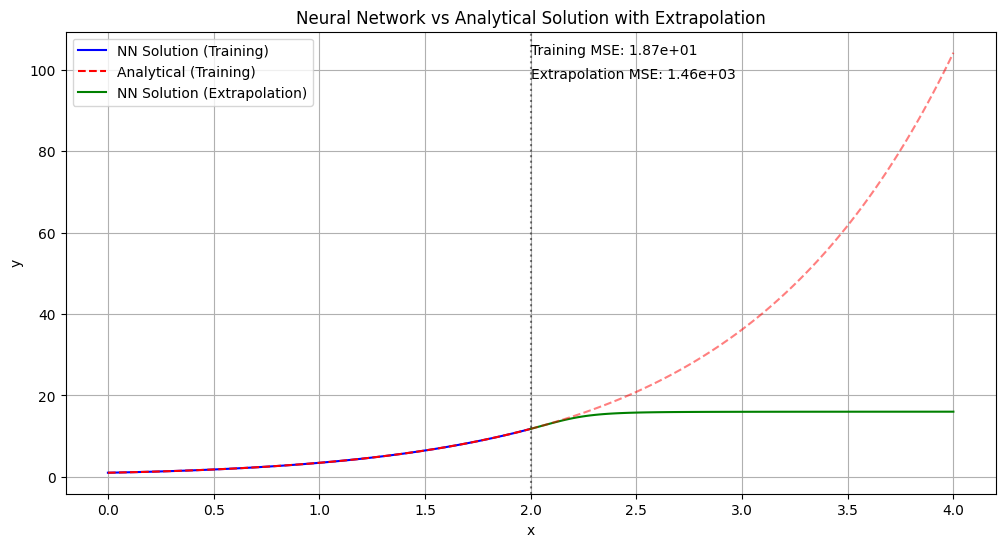

In [35]:
# Running Experiment 1
print("\n" + "="*80)
print("Experiment 1: Basic IVP Solver (y' = y + x)")
print("="*80)

def f(x, y): return y + x
def analytical_solution(x): return 2 * torch.exp(x) - x - 1

# Params
x0, y0 = 0.0, 1.0  # Initial condition
x_train_range = (0, 2)
x_test_range = (2, 4)

ivp_model = ODENetwork(hidden_dim=20, num_layers=2)
loss_history = train_linear_ivp(ivp_model, f, x0, y0, x_range=x_train_range)

train_err, test_err = plot_linear_solution(
    ivp_model, analytical_solution, x_train_range, x_test_range
)

# Experiment 2: Basic PINN for a periodic function (y' = cos(t))

In [36]:
# Training
def train_sine_pinn(
    model: nn.Module,
    x_range: Tuple[float, float] = (0, 6*np.pi),
    num_points: int = 300,
    num_epochs: int = 5000,
    learning_rate: float = 0.001,
    verbose: bool = True
) -> List[float]:

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    t_collocation = torch.linspace(x_range[0], x_range[1], num_points).reshape(-1, 1)

    initial_t = torch.tensor([[0.0]])
    initial_y = torch.tensor([[0.0]])  # sin(0) = 0

    loss_history = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        t_calc = t_collocation.clone().detach().requires_grad_(True)
        y = model(t_calc)
        dy_dt = torch.autograd.grad(
            y,
            t_calc,
            grad_outputs=torch.ones_like(y),
            create_graph=True
        )[0]

        ode_residual = dy_dt - torch.cos(t_calc)
        physics_loss = torch.mean(ode_residual**2)

        pred_initial = model(initial_t)
        ic_loss = torch.mean((pred_initial - initial_y)**2)

        total_loss = physics_loss + ic_loss

        total_loss.backward()
        optimizer.step()

        loss_history.append(total_loss.item())

        if verbose and (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}, Total Loss: {total_loss.item():.6f}, "
                  f"Physics Loss: {physics_loss.item():.6f}, "
                  f"IC Loss: {ic_loss.item():.6f}")

    return loss_history

In [37]:
#Plotting
def plot_sine_solution(
    model: nn.Module,
    train_range: Tuple[float, float],
    test_range: Tuple[float, float],
    num_points: int = 200,
    plot_loss: bool = False,
    loss_history: Optional[List[float]] = None
):
    with torch.no_grad():
        t_train = torch.linspace(train_range[0], train_range[1], num_points).reshape(-1, 1)
        t_test = torch.linspace(test_range[0], test_range[1], num_points).reshape(-1, 1)

        y_train_pred = model(t_train).detach().cpu().numpy()
        y_test_pred = model(t_test).detach().cpu().numpy()

        t_train = t_train.numpy()
        t_test = t_test.numpy()

    y_train_true = np.sin(t_train)
    y_test_true = np.sin(t_test)

    if plot_loss and loss_history:
        plt.figure(figsize=(15, 10))

        # Training domain plot
        plt.subplot(2, 2, (1, 2))
    else:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)

    plt.plot(t_train, y_train_true, 'b-', label='True Solution', alpha=0.7)
    plt.plot(t_train, y_train_pred, 'r--', label='NN Solution')
    plt.title(f'Training Domain ({train_range[0]} to {train_range[1]})')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)

    # Extrapolation domain plot
    if plot_loss and loss_history:
        plt.subplot(2, 2, 3)
    else:
        plt.subplot(1, 2, 2)

    plt.plot(t_test, y_test_true, 'b-', label='True Solution', alpha=0.7)
    plt.plot(t_test, y_test_pred, 'r--', label='NN Solution')
    plt.title(f'Extrapolation Domain ({test_range[0]} to {test_range[1]})')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)

    # Training loss plot
    if plot_loss and loss_history:
        plt.subplot(2, 2, 4)
        plt.semilogy(loss_history)
        plt.title('Training Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss (log scale)')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Compute error metrics
    train_mse = np.mean((y_train_true - y_train_pred)**2)
    test_mse = np.mean((y_test_true - y_test_pred)**2)
    train_max_error = np.max(np.abs(y_train_true - y_train_pred))
    test_max_error = np.max(np.abs(y_test_true - y_test_pred))

    print(f'Training MSE: {train_mse:.6f}')
    print(f'Test MSE: {test_mse:.6f}')
    print(f'Maximum Training Error: {train_max_error:.6f}')
    print(f'Maximum Test Error: {test_max_error:.6f}')

    return train_mse, test_mse, train_max_error, test_max_error



Experiment 2: Basic PINN Solver for Sine Function (y' = cos(t))
Epoch 500, Total Loss: 0.000097, Physics Loss: 0.000092, IC Loss: 0.000005
Epoch 1000, Total Loss: 0.000020, Physics Loss: 0.000020, IC Loss: 0.000000
Epoch 1500, Total Loss: 0.000008, Physics Loss: 0.000008, IC Loss: 0.000000
Epoch 2000, Total Loss: 0.001346, Physics Loss: 0.000065, IC Loss: 0.001281
Epoch 2500, Total Loss: 0.000004, Physics Loss: 0.000004, IC Loss: 0.000000
Epoch 3000, Total Loss: 0.001024, Physics Loss: 0.000057, IC Loss: 0.000968
Epoch 3500, Total Loss: 0.000001, Physics Loss: 0.000001, IC Loss: 0.000000
Epoch 4000, Total Loss: 0.000001, Physics Loss: 0.000001, IC Loss: 0.000000
Epoch 4500, Total Loss: 0.000061, Physics Loss: 0.000004, IC Loss: 0.000058
Epoch 5000, Total Loss: 0.000000, Physics Loss: 0.000000, IC Loss: 0.000000


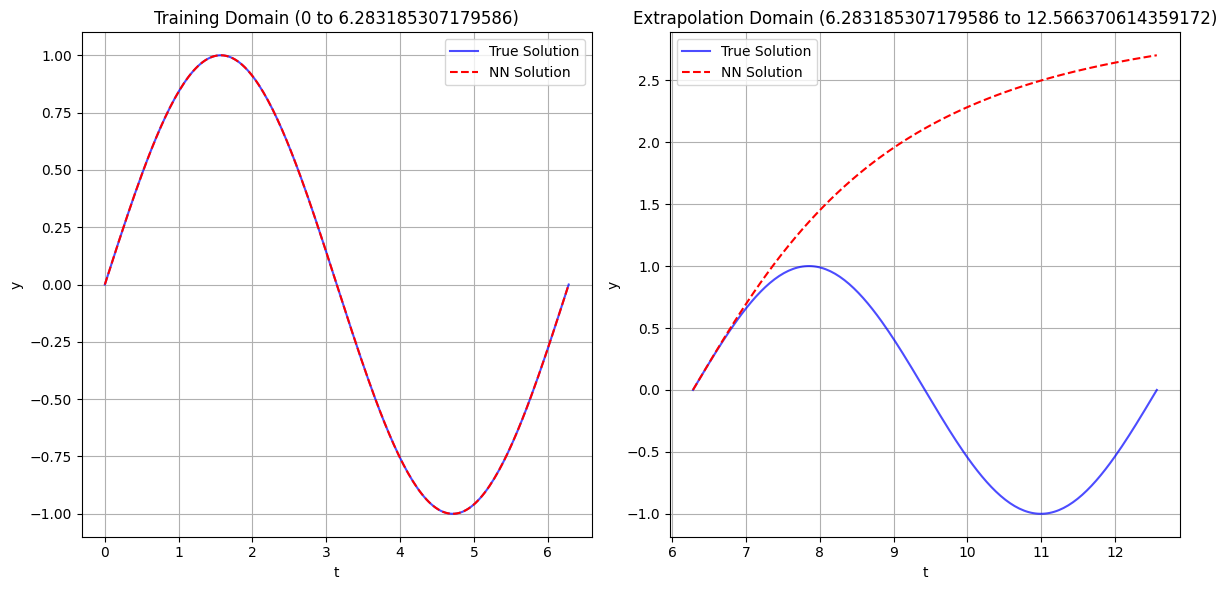

Training MSE: 0.000000
Test MSE: 5.277113
Maximum Training Error: 0.000133
Maximum Test Error: 3.511866


(np.float32(5.9242065e-09),
 np.float32(5.2771134),
 np.float32(0.00013311207),
 np.float32(3.5118656))

In [38]:
# Run Experiment 2
print("\n" + "="*80)
print("Experiment 2: Basic PINN Solver for Sine Function (y' = cos(t))")
print("="*80)

# Parameters
t_train_range = (0, 2*np.pi)
t_test_range = (2*np.pi, 4*np.pi)

# Create and train the model
sine_model = ODENetwork(hidden_dim=50, num_layers=3)
loss_history = train_sine_pinn(sine_model, t_train_range)

# Plot results
plot_sine_solution(sine_model, t_train_range, t_test_range)

# Experiment 3: Extended training domain for the periodic function


Experiment 3: Extended Training Domain for Sine Function
Epoch 500, Total Loss: 0.173851, Physics Loss: 0.173842, IC Loss: 0.000009
Epoch 1000, Total Loss: 0.000128, Physics Loss: 0.000121, IC Loss: 0.000007
Epoch 1500, Total Loss: 0.000025, Physics Loss: 0.000023, IC Loss: 0.000002
Epoch 2000, Total Loss: 0.000008, Physics Loss: 0.000008, IC Loss: 0.000000
Epoch 2500, Total Loss: 0.000004, Physics Loss: 0.000004, IC Loss: 0.000000
Epoch 3000, Total Loss: 0.000002, Physics Loss: 0.000002, IC Loss: 0.000000
Epoch 3500, Total Loss: 0.000002, Physics Loss: 0.000001, IC Loss: 0.000000
Epoch 4000, Total Loss: 0.000008, Physics Loss: 0.000004, IC Loss: 0.000004
Epoch 4500, Total Loss: 0.000005, Physics Loss: 0.000004, IC Loss: 0.000001
Epoch 5000, Total Loss: 0.000005, Physics Loss: 0.000001, IC Loss: 0.000004


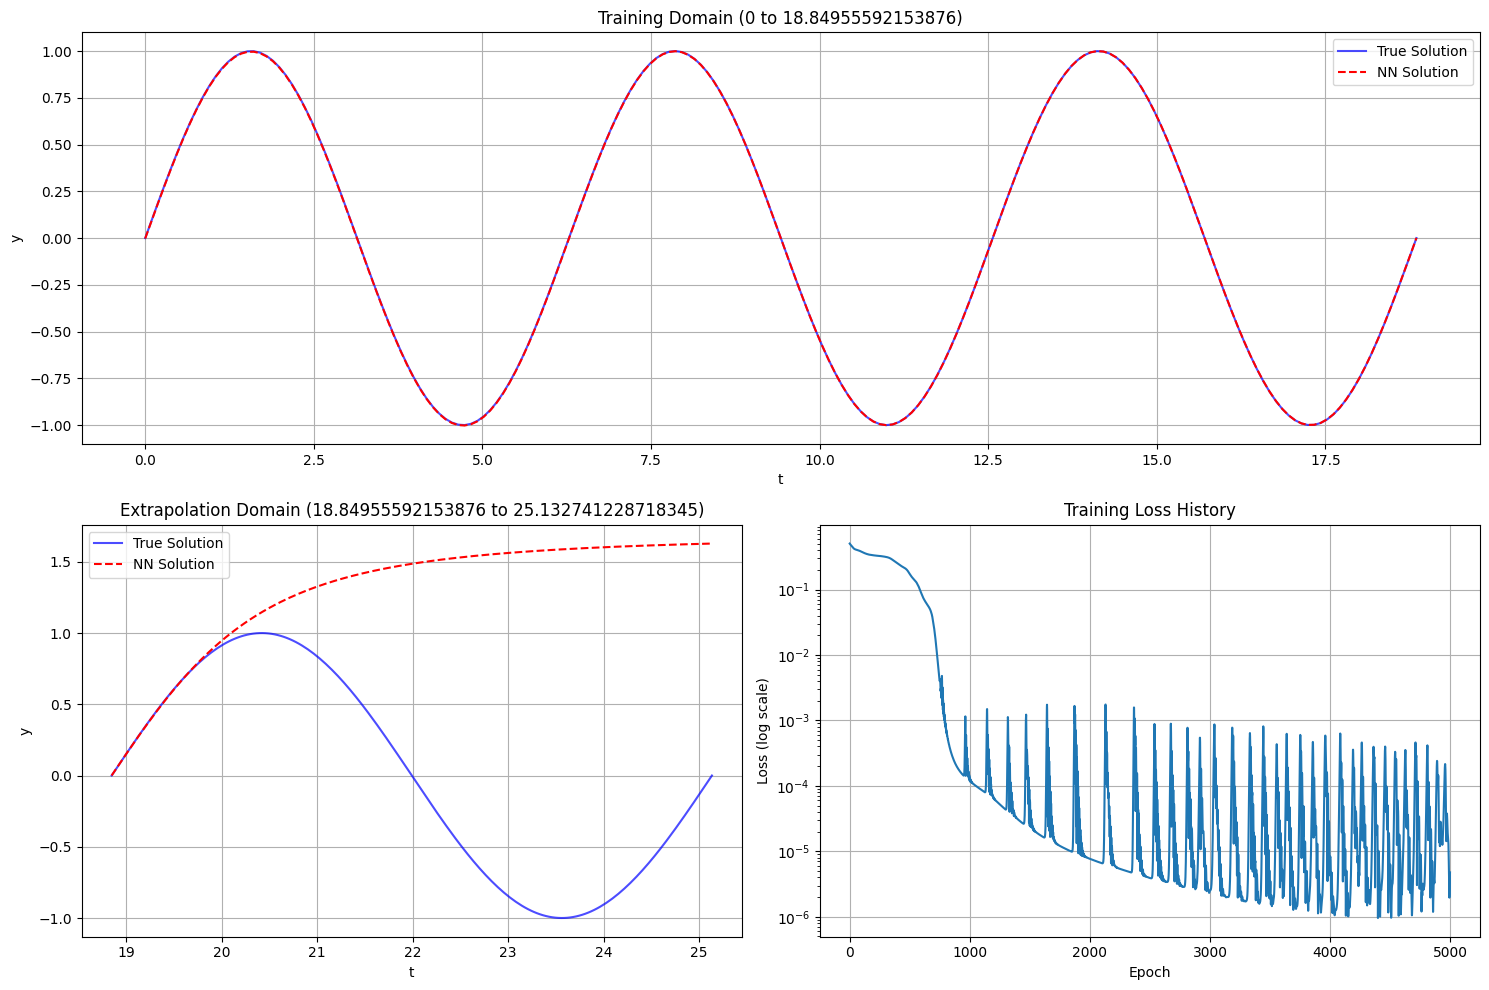

Training MSE: 0.000002
Test MSE: 2.664881
Maximum Training Error: 0.002876
Maximum Test Error: 2.588140


(np.float32(2.4128715e-06),
 np.float32(2.664881),
 np.float32(0.0028761625),
 np.float32(2.5881405))

In [39]:
# Run Experiment 3
print("\n" + "="*80)
print("Experiment 3: Extended Training Domain for Sine Function")
print("="*80)

t_train_range_ext = (0, 6*np.pi)
t_test_range_ext = (6*np.pi, 8*np.pi)

sine_model_ext = ODENetwork(hidden_dim=50, num_layers=3)
loss_history_ext = train_sine_pinn(sine_model_ext, t_train_range_ext)

plot_sine_solution(
    sine_model_ext, t_train_range_ext, t_test_range_ext,
    plot_loss=True, loss_history=loss_history_ext
)

# Experiment 4: Fourier-enhanced PINN

In [40]:
# Fourier features
class FourierFeatures(nn.Module):
    def __init__(self, num_frequencies: int = 10):
        super().__init__()
        self.num_frequencies = num_frequencies
        self.frequencies = nn.Parameter(torch.linspace(1, num_frequencies, num_frequencies))

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        features = []
        for freq in self.frequencies:
            features.append(torch.sin(freq * t))
            features.append(torch.cos(freq * t))
        features.append(t)  # Add original input

        return torch.cat(features, dim=1)

In [41]:
class FourierPINN(nn.Module):
    def __init__(self, num_frequencies: int = 10, hidden_dim: int = 128, num_layers: int = 3):
        super().__init__()
        self.fourier_features = FourierFeatures(num_frequencies=num_frequencies)

        input_dim = 2 * num_frequencies + 1

        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, 1))

        self.net = nn.Sequential(*layers)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        features = self.fourier_features(t)
        return self.net(features)

    def compute_derivative(self, t: torch.Tensor) -> torch.Tensor:
        t.requires_grad_(True)
        y = self.forward(t)
        dy_dt = torch.autograd.grad(
            y, t,
            grad_outputs=torch.ones_like(y),
            create_graph=True
        )[0]
        return dy_dt

# Training
def train_fourier_pinn(
    model: FourierPINN,
    x_range: Tuple[float, float] = (0, 6*np.pi),
    num_points: int = 500,
    num_epochs: int = 5000,
    learning_rate: float = 0.001,
    verbose: bool = True
) -> List[float]:
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=200, factor=0.5
    )

    t_collocation = torch.linspace(x_range[0], x_range[1], num_points).reshape(-1, 1)

    initial_points = torch.tensor([[0.0], [2*np.pi], [4*np.pi]])
    initial_values = torch.sin(initial_points)

    # Period for periodicity constraint
    period = 2*np.pi
    t_periodic = torch.linspace(0, 4*np.pi, 100).reshape(-1, 1)

    loss_history = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        dy_dt = model.compute_derivative(t_collocation)
        ode_residual = dy_dt - torch.cos(t_collocation)
        physics_loss = torch.mean(ode_residual**2)

        pred_values = model(initial_points)
        bc_loss = torch.mean((pred_values - initial_values)**2)

        y_t = model(t_periodic)
        y_t_plus_period = model(t_periodic + period)
        periodicity_loss = torch.mean((y_t - y_t_plus_period)**2)

        # Total loss with weighting
        total_loss = physics_loss + 10.0*bc_loss + 5.0*periodicity_loss

        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)

        loss_history.append(total_loss.item())

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch}, Total Loss: {total_loss.item():.6f}, "
                  f"Physics Loss: {physics_loss.item():.6f}, "
                  f"BC Loss: {bc_loss.item():.6f}, "
                  f"Periodicity Loss: {periodicity_loss.item():.6f}")

    return loss_history


Experiment 4: Fourier PINN for Improved Periodicity
Epoch 0, Total Loss: 6.486234, Physics Loss: 4.668506, BC Loss: 0.163554, Periodicity Loss: 0.036437
Epoch 500, Total Loss: 0.000373, Physics Loss: 0.000348, BC Loss: 0.000001, Periodicity Loss: 0.000003
Epoch 1000, Total Loss: 0.000085, Physics Loss: 0.000084, BC Loss: 0.000000, Periodicity Loss: 0.000000
Epoch 1500, Total Loss: 0.000051, Physics Loss: 0.000040, BC Loss: 0.000001, Periodicity Loss: 0.000000
Epoch 2000, Total Loss: 0.000020, Physics Loss: 0.000020, BC Loss: 0.000000, Periodicity Loss: 0.000000
Epoch 2500, Total Loss: 0.000012, Physics Loss: 0.000012, BC Loss: 0.000000, Periodicity Loss: 0.000000
Epoch 3000, Total Loss: 0.000008, Physics Loss: 0.000008, BC Loss: 0.000000, Periodicity Loss: 0.000000
Epoch 3500, Total Loss: 0.000471, Physics Loss: 0.000063, BC Loss: 0.000040, Periodicity Loss: 0.000001
Epoch 4000, Total Loss: 0.000004, Physics Loss: 0.000004, BC Loss: 0.000000, Periodicity Loss: 0.000000
Epoch 4500, Tot

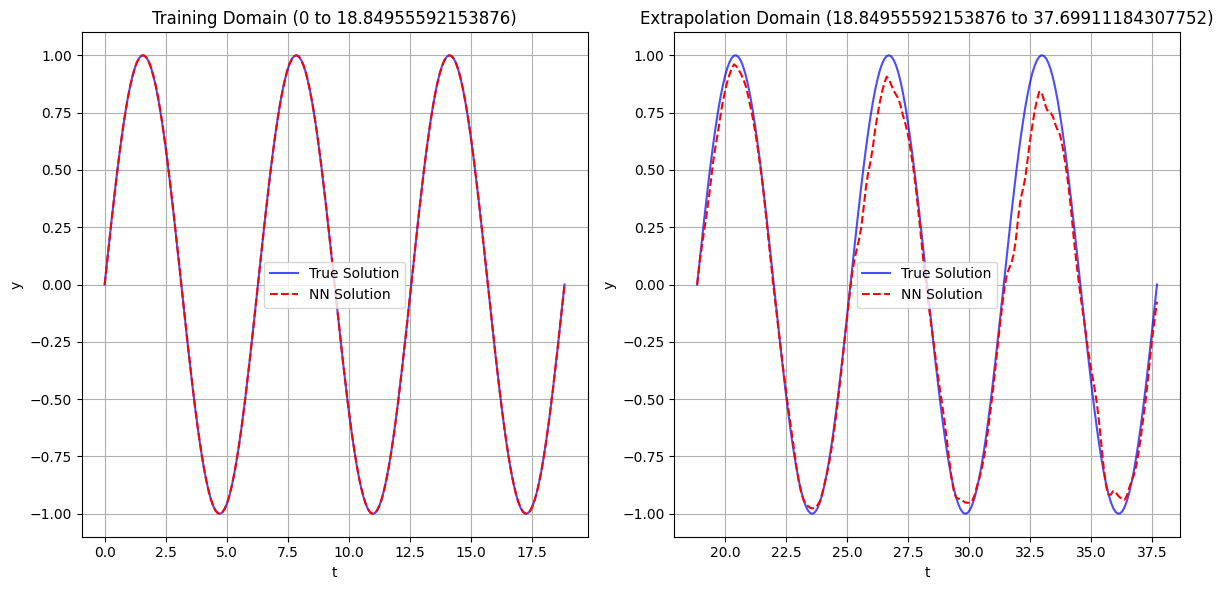

Training MSE: 0.000000
Test MSE: 0.009097
Maximum Training Error: 0.000160
Maximum Test Error: 0.307288


(np.float32(3.868331e-09),
 np.float32(0.009097386),
 np.float32(0.00015963614),
 np.float32(0.307288))

In [42]:
# Run Experiment 4
print("\n" + "="*80)
print("Experiment 4: Fourier PINN for Improved Periodicity")
print("="*80)

t_train_range_four = (0, 6*np.pi)
t_test_range_four = (6*np.pi, 12*np.pi)

fourier_model = FourierPINN(num_frequencies=10, hidden_dim=128, num_layers=3)
loss_history_four = train_fourier_pinn(fourier_model, t_train_range_four)

plot_sine_solution(fourier_model, t_train_range_four, t_test_range_four)